In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from keras.models import Model

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 5.4 MB/s 


In [ ]:
# import patoolib
# patoolib.extract_archive("/content/drive/MyDrive/Annotation.zip", outdir="/content/drive/MyDrive/Train")

patool: Extracting /content/drive/MyDrive/Annotation.zip ...
patool: running /usr/bin/7z x -o/content/drive/MyDrive/Train -- /content/drive/MyDrive/Annotation.zip
patool: ... /content/drive/MyDrive/Annotation.zip extracted to `/content/drive/MyDrive/Train'.


'/content/drive/MyDrive/Train'

In [ ]:
img_dim = 256

train_data_dir = '/content/drive/MyDrive/Train'
anno_data_dir = '/content/drive/MyDrive/Train'

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_image_generator = image_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['Final_data_daxoay'],
        batch_size = 32,
        seed=42,
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        anno_data_dir,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['Annotation'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['Final_data_daxoay'],
        batch_size = 32,
        seed=42,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        anno_data_dir,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['Annotation'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 1689 images belonging to 1 classes.
Found 1689 images belonging to 1 classes.
Found 422 images belonging to 1 classes.
Found 422 images belonging to 1 classes.


In [ ]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

# Visualization
+ 2 class: 
  + Ngón tay
  + Cảnh, đối tượng


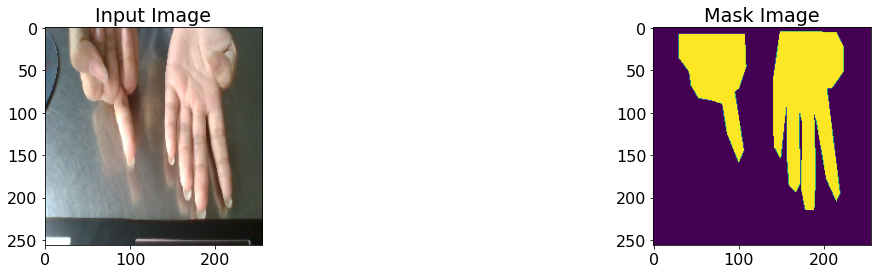

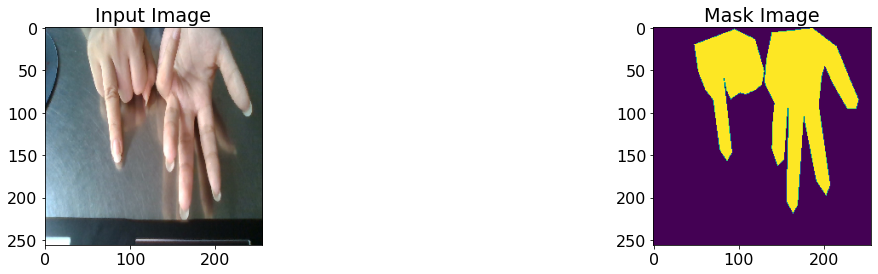

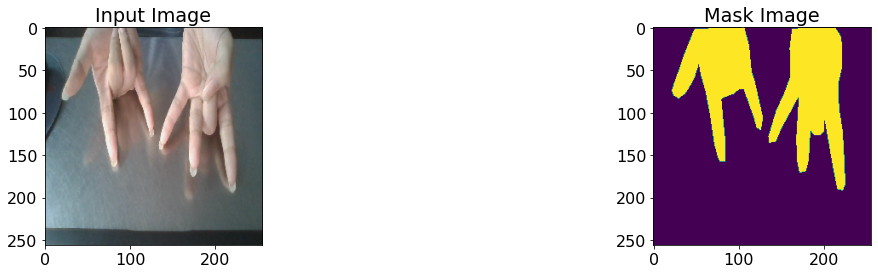

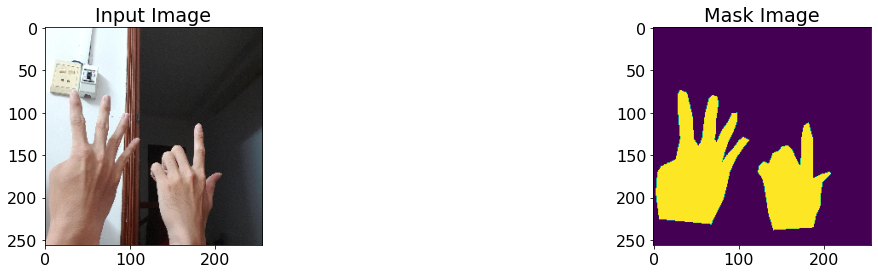

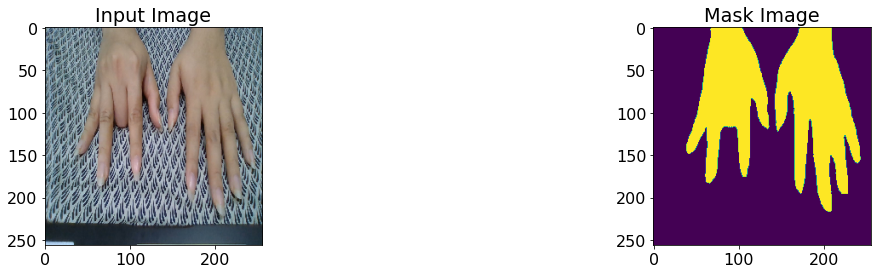

In [ ]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(np.squeeze(mask[0]))
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

# U-Net

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

# Custom Metrics
- Số liệu quan trọng nhất trong các tác vụ phân đoạn ảnh luôn là IoU (Intersection over Union), là một phương pháp để định lượng phần trăm trùng lặp giữa mark và output.

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2022/04/fig2.png">

In [ ]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Tính toán các khu vực (cần thiết để tìm sự kết hợp giữa tất cả các đối tượng)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    
    union = area_true + area_pred - intersection

    # Loại trừ nền 
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9


    iou = intersection / union


    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn


    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

# Model Training
- Compile mô hình và đặt các siêu tham số
- Thêm callbacks
- Thêm iou_loss để tối ưu hóa hoặc lấy trung bình có trọng số của binara-crossentropy và iou để tối ưu hóa các tham số của mô hình

In [ ]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape)
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ormalization)                                                                                    
                                                                                                  
 activation_12 (Activation)     (None, 64, 64, 128)  0           ['batch_normalization_12[0][0]'] 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 64, 64, 128)  147584      ['activation_12[0][0]']          
                                                                                                  
 batch_normalization_13 (BatchN  (None, 64, 64, 128)  512        ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 64, 64, 128)  0           ['batch_normalization_13[0][0]'] 
          

In [ ]:
model_path = "unet_maimai.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 4,
                          verbose = 1,
                          restore_best_weights = True)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=training_samples_size//32,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//32,
                    epochs=50, callbacks=[earlystop, checkpoint])

Epoch 1/50
52/52 [==============================] - ETA: 0s - loss: 0.2654 - iou_coef: 0.5215 - accuracy: 0.9044
Epoch 1: val_loss improved from inf to 23.05948, saving model to unet_maimai.h5
52/52 [==============================] - 188s 3s/step - loss: 0.2654 - iou_coef: 0.5215 - accuracy: 0.9044 - val_loss: 23.0595 - val_iou_coef: 0.2017 - val_accuracy: 0.2449
Epoch 2/50
52/52 [==============================] - ETA: 0s - loss: 0.1613 - iou_coef: 0.6514 - accuracy: 0.9440
Epoch 2: val_loss improved from 23.05948 to 4.63663, saving model to unet_maimai.h5
52/52 [==============================] - 161s 3s/step - loss: 0.1613 - iou_coef: 0.6514 - accuracy: 0.9440 - val_loss: 4.6366 - val_iou_coef: 0.2523 - val_accuracy: 0.4440
Epoch 3/50
52/52 [==============================] - ETA: 0s - loss: 0.1383 - iou_coef: 0.6942 - accuracy: 0.9503
Epoch 3: val_loss improved from 4.63663 to 1.46833, saving model to unet_maimai.h5
52/52 [==============================] - 161s 3s/step - loss: 0.1383 

In [ ]:
import seaborn as sns
# sns.set_style('dark')

## Biểu đồ loss

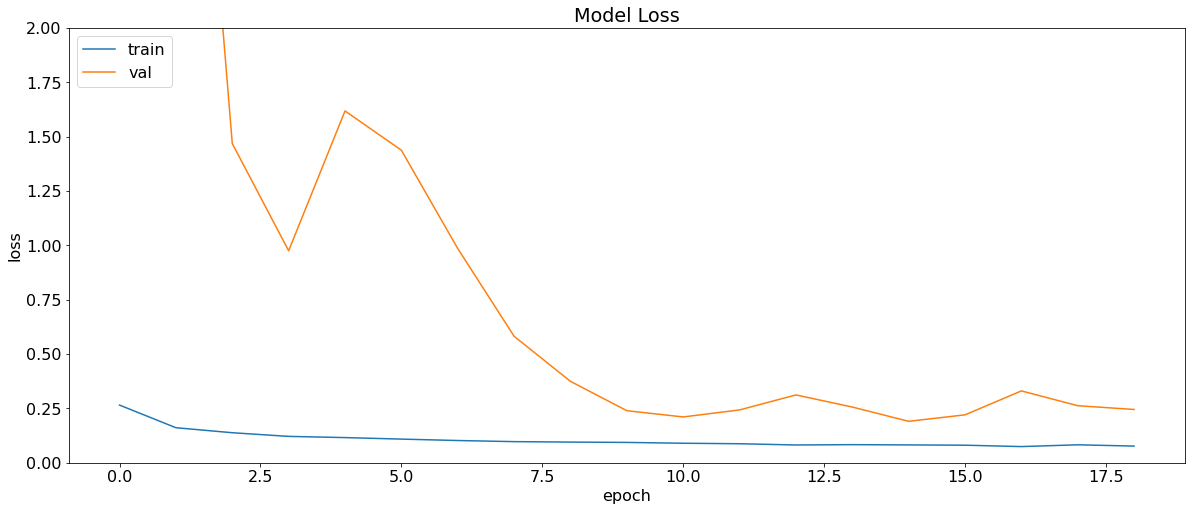

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
random_val_samples = val_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = model.predict(val_image_samples)

predicted_masks[predicted_masks >= 0.5] = 1
predicted_masks[predicted_masks < 0.5] = 0

1/1 [==============================] - 0s 386ms/step


## Trực quan hoá Masks vs Predicted Masks

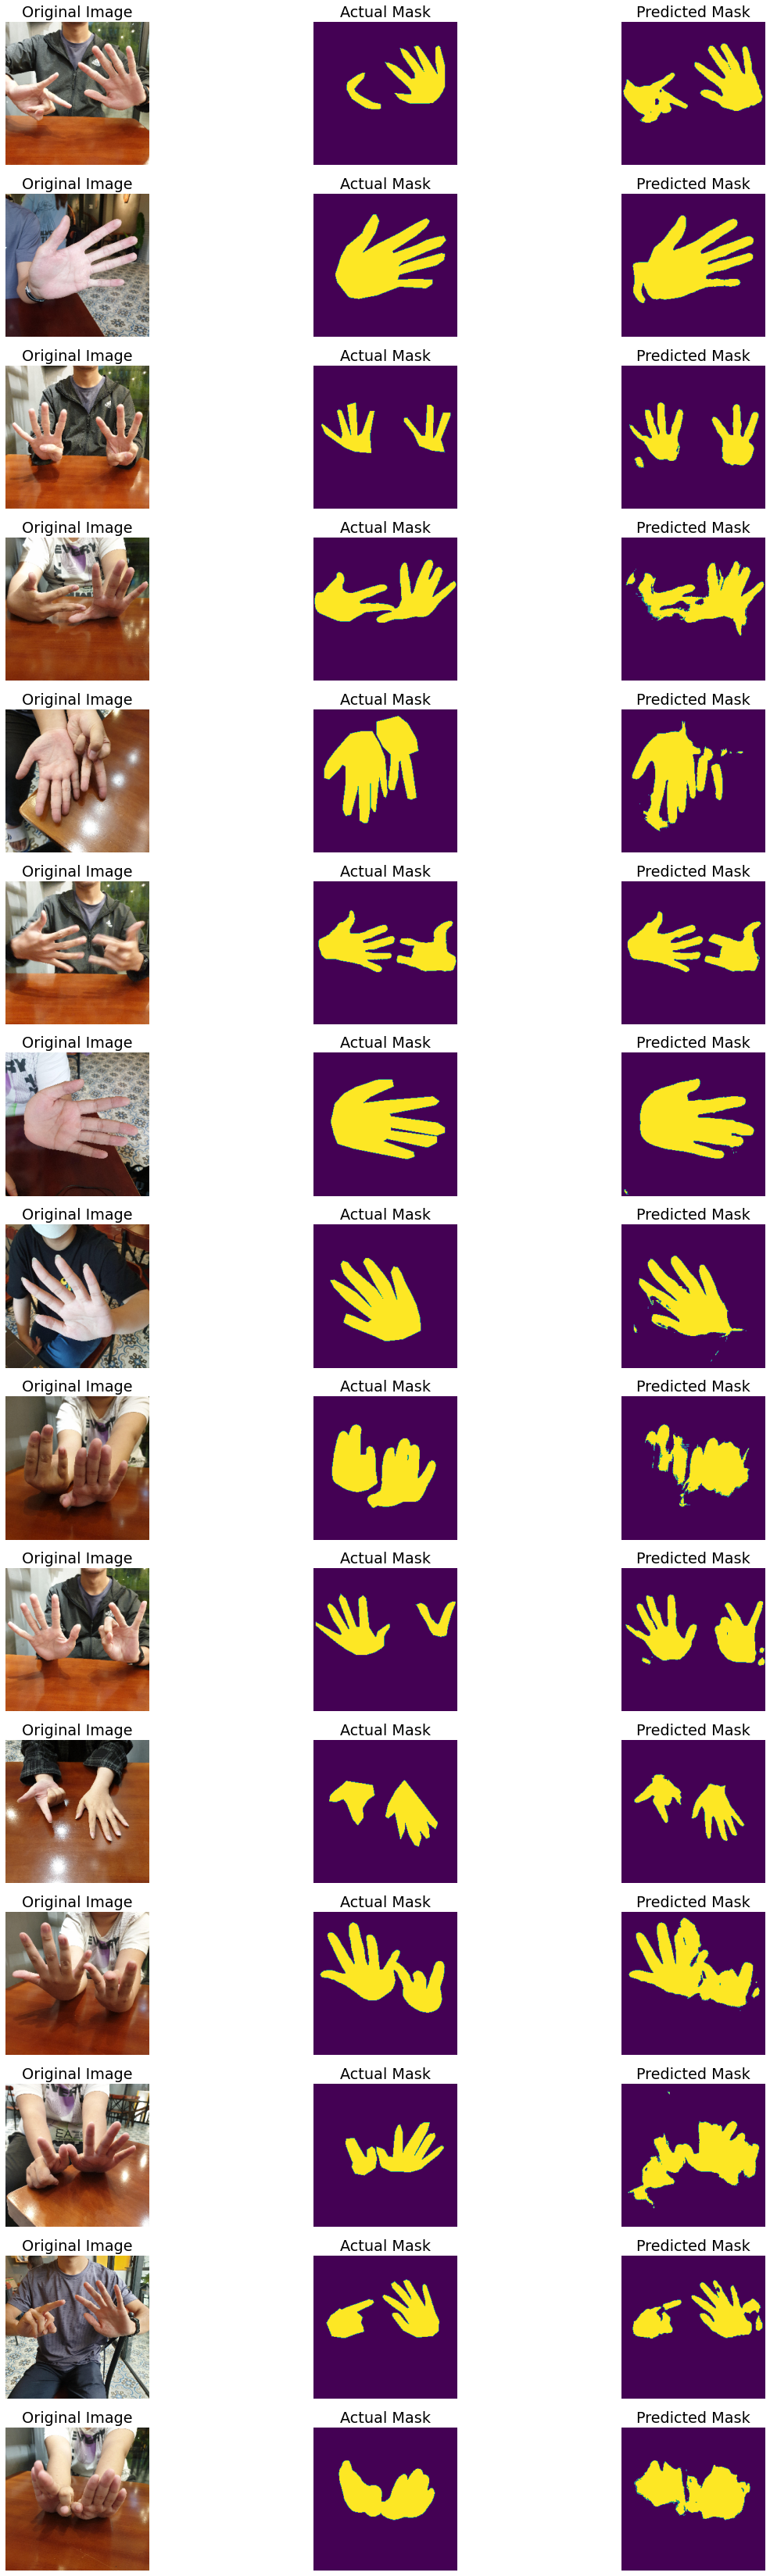

In [ ]:
f, axarr = plt.subplots(15,3,figsize=(20, 60))

for i in range(0,15):

    axarr[i,0].imshow(np.squeeze(val_image_samples[i]))
    axarr[i,0].title.set_text('Original Image')
    axarr[i,0].axis('off')
    
    axarr[i,1].imshow(np.squeeze(val_mask_samples[i]))
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,1].axis('off')
    axarr[i,2].imshow(np.squeeze(predicted_masks[i]))
    axarr[i,2].title.set_text('Predicted Mask')
    axarr[i,2].axis('off')

# Kết luận
- Trong một số trường hợp, mark được phân đoạn không khớp với mark thực tế. Lý do là một số hình ảnh không được dán nhãn chính xác trong quá trình annotation dữ liệu, ảnh và mark khác chiều.., ngoài ra còn có sự ảnh hưởng của ngoại cảnh.
- mô hình có thể xác định một số đặc trưng giúp phân đoạn các các kí hiệu số đếm tay từ 5 đến 9 không được gắn nhãn trong hình ảnh thực tế
